# Introduction

This workbook fits a Gaussian Process model to the Random and Sobol data. 

In [1]:
import GPy
import pandas as pd
import patsy as pt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
%matplotlib inline
import re
import pymc3 as pm

In [2]:
!python clean_results.py

In [3]:
df = pd.read_csv('results/results_clean.csv')
print(df.dtypes)
df.head()


method          object
test_scores     object
train_scores    object
basis           object
lag_time         int64
n_components     int64
n_clusters       int64
dtype: object


,method,test_scores,train_scores,basis,lag_time,n_components,n_clusters
0,bayesian,"[1.3776911158951748, 1.3740749840217341, 1.264...","[2.9389462312306645, 2.950642052871998, 2.9298...",close_cont,868,7,216
1,bayesian,"[1.0684842211915222, 1.1161358818514298, 1.143...","[2.0313664449993496, 1.902029834442478, 1.9717...",chi_tor,123,8,719
2,bayesian,"[1.419293959877178, 2.459780516990084, 1.42471...","[2.9952122086182973, 2.9991551430503254, 2.996...",alpha_angle,528,9,503
3,bayesian,"[1.266771869867596, 2.1699129867494955, 2.1975...","[2.9829218758783957, 2.994692237174925, 2.9937...",all_tor,909,6,245
4,bayesian,"[1.502631858780357, 2.094233568665083, 1.25880...","[2.998903280162028, 2.993679670790958, 2.99892...",close-h_cont,228,10,990


In [4]:
df.loc[:, 'id'] = np.arange(df.shape[0])+1

Convert score fields to numeric lists, not strings. 

In [5]:
def to_float(x):
    nums = re.findall('[0-9]+\\.[0-9]+', string=x)
    nums = [float(y) for y in nums]
    return nums

df.loc[:, 'test_scores'] = df.loc[:, 'test_scores'].apply(to_float)
df.loc[:, 'train_scores'] = df.loc[:, 'train_scores'].apply(to_float)

Expand out the individual list scores and label the fold numbers

In [6]:
lst_cols = ['test_scores', 'train_scores']
n_folds = df[lst_cols[0]].str.len()[0] # Assumes all the lists are the same length! 

df_long = pd.DataFrame({
      col:np.repeat(df[col].values, df[lst_cols[0]].str.len())
      for col in df.columns.drop(lst_cols)}
    ).\
assign(fold_num = np.concatenate([np.arange(1, x+1) for x in df[lst_cols[0]].str.len()])).\
assign(**{lst_col:np.concatenate(df[lst_col].values) for lst_col in lst_cols })


In [7]:
df_long.query('method=="random"')

,method,basis,lag_time,n_components,n_clusters,id,fold_num,test_scores,train_scores
7835,random,all_tor,861,8,424,1568,1,1.909310,2.947081
7836,random,all_tor,861,8,424,1568,2,1.698505,2.996456
7837,random,all_tor,861,8,424,1568,3,2.276155,2.995918
7838,random,all_tor,861,8,424,1568,4,1.649213,2.786009
7839,random,all_tor,861,8,424,1568,5,1.687259,2.997979
...,...,...,...,...,...,...,...,...,...
20630,random,ppo_tor,230,8,724,4127,1,1.683005,2.995281
20631,random,ppo_tor,230,8,724,4127,2,1.141850,2.999343
20632,random,ppo_tor,230,8,724,4127,3,1.369045,2.994739
20633,random,ppo_tor,230,8,724,4127,4,2.064755,2.751816


Rescale the lag time 

In [8]:
df_long['lag_time'] *= 0.5

Rename the columns

In [9]:
df_long.rename(columns={'test_scores': 'test_score', 'train_scores': 'train_score'}, inplace=True)

In [10]:
df_basis_method = df_long.loc[:, ['id', 'basis', 'method']].drop_duplicates()

In [11]:
df_basis_method.head()

,id,basis,method
0,1,close_cont,bayesian
5,2,chi_tor,bayesian
10,3,alpha_angle,bayesian
15,4,all_tor,bayesian
20,5,close-h_cont,bayesian


In [12]:
df_ave = df_long.groupby('id').mean().reset_index()
df_ave = df_basis_method.merge(df_ave, on='id', how='inner')

## Fit model - ppo torsions only

First generate a data matrix

In [104]:
ppo_rand_idx = (df_ave['basis']=='ppo_tor') & (df_ave['method'] == 'random')

form = 'test_score ~ -1 + n_clusters + lag_time + n_components'
y_obs, x_obs = pt.dmatrices(form, df_ave.loc[ppo_rand_idx, :], return_type='dataframe')

Scale each value to be in the interval (0, 1)

In [105]:
from sklearn.preprocessing import MinMaxScaler
unit_scaler = MinMaxScaler(feature_range=(0, 1))
x_scaled = pd.DataFrame(unit_scaler.fit_transform(x_obs), columns=x_obs.columns)
x_scaled.head()

,n_clusters,lag_time,n_components
0,0.460914,0.028283,0.666667
1,0.718782,0.863636,0.111111
2,0.422335,0.117172,1.000000
3,0.893401,0.569697,0.111111
4,0.539086,0.482828,0.444444


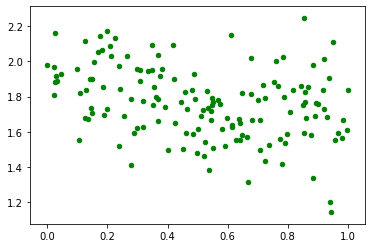

In [130]:
plt.scatter(x_scaled.loc[:, 'n_clusters'].values, y_obs, color='g', s=20, alpha=1)

In [ ]:
plt.scatter(x_obs.loc[:, 'n_componen'])

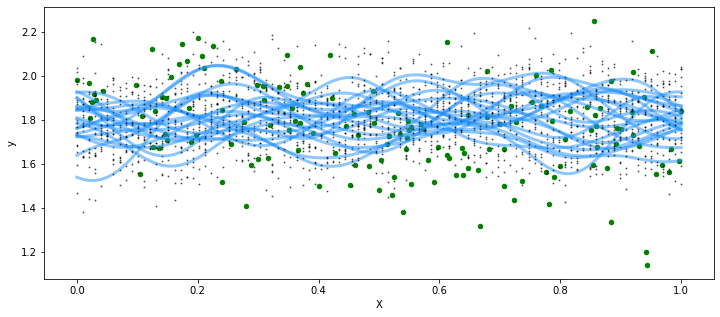

In [135]:
# set the seed
np.random.seed(1)
fig, ax = plt.subplots(figsize=(12,5))
n = 100 # The number of data points
X = np.linspace(0, 1, n)[:, None] # The inputs to the GP, they must be arranged as a column vector

# Define the true covariance function and its parameters
l_true = 0.1
eta_true = 0.1
cov_func = eta_true**2 * pm.gp.cov.ExpQuad(1, l_true)

# A mean function that is zero everywhere
mean_func = pm.gp.mean.Constant(c=1.8)

for i in range(20):
    # The latent function values are one sample from a multivariate normal
    # Note that we have to call `eval()` because PyMC3 built on top of Theano
    f_true = np.random.multivariate_normal(mean_func(X).eval(),
                                           cov_func(X).eval() + 1e-8*np.eye(n), 1).flatten()

    # The observed data is the latent function plus a small amount of T distributed noise
    # The standard deviation of the noise is `sigma`, and the degrees of freedom is `nu`
    sigma_true = 0.1
    y = f_true + np.random.normal(size=n, loc=0, scale=sigma_true)

    ## Plot the data and the unobserved latent function

    ax.plot(X, f_true, "dodgerblue", lw=3, label="True f", alpha=0.5);
    ax.plot(X, y, 'ok', ms=1, label="Data",alpha=0.5);
    ax.set_xlabel("X"); ax.set_ylabel("y");


ax.scatter(x_scaled.loc[:, 'n_clusters'].values, y_obs, color='g', s=20, alpha=1)

In [118]:
?np.random.normal

Compose a multiplicative kernel. Set the variance to be the overall global variance as a good starting point. 

In [101]:
with pm.Model() as model:
    
    ℓ = pm.Gamma("ℓ", alpha=2, beta=1)
    η = pm.HalfCauchy("η", beta=5)

    cov = η**2 * pm.gp.cov.ExpQuad(1, ℓ)
    gp = pm.gp.Latent(cov_func=cov)

    f = gp.prior("f", X=X[:10, :])

    σ = pm.HalfCauchy("σ", beta=5)
    y_ = pm.Normal("y", mu=f, sigma=σ, observed=y[:10])

    trace = pm.sample(1000, chains=1)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
 /Users/robertarbon/OneDrive - University of Bristol/Research/optimize_fs_peptide/opt_fs_pep/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Sequential sampling (1 chains in 1 job)
NUTS: [σ, f_rotated_, η, ℓ]
Sampling chain 0, 46 divergences: 100%|██████████| 1500/1500 [01:48<00:00, 13.77it/s]
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


# Build up model

## PPO basis, y ~ n_clusters

In [ ]:
ppo_rand_idx = df_rand['basis']=='ppo_tor'
form = 'mean_test_score ~ -1 + n_clusters'
y, x = pt.dmatrices(form, df_rand.loc[ppo_rand_idx, :], return_type='dataframe')

In [ ]:
kernel = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)
m = GPy.models.GPRegression(x, y,kernel)
_ = m.optimize_restarts(num_restarts = 10, verbose=False)

In [ ]:
with sns.plotting_context():
    fig, ax = plt.subplots()
    m.plot(ax=ax)
    ax.set_xlim(0, 1000)
    ax.set_ylim(0, 5)

## PPO basis, y ~ n_clusters + lag_time

In [ ]:
ppo_rand_idx = df_rand['basis']=='ppo_tor'
form = 'mean_test_score ~ -1 + n_clusters + lag_time'
y, x = pt.dmatrices(form, df_rand.loc[ppo_rand_idx, :], return_type='dataframe')
x_scale = preprocessing.scale(x)

In [ ]:
kernel = np.sum([GPy.kern.RBF(input_dim=1, ARD=True, active_dims=[i]) for i in range(2)])
m = GPy.models.GPRegression(x_scale, y,kernel)
_ = m.optimize_restarts(num_restarts = 50, verbose=False)

In [ ]:
m.plot()


In [ ]:
for x2_new in [-2, 0, 2]:
    
    x_new = np.concatenate((np.linspace(-3,3, 100)[:, np.newaxis], x2_new*np.ones(100)[:, np.newaxis]), axis=1)

    mean, var = m.predict(Xnew=x_new)
    plt.plot(mean)


## PPO basis, y ~ n_clusters + lag_time + n_components

## Fit model

In [ ]:
ppo_rand_idx = df_rand['basis']=='ppo_tor'
form = 'mean_test_score ~ -1 + n_clusters + lag_time + n_components'
y, x = pt.dmatrices(form, df_rand.loc[ppo_rand_idx, :], return_type='dataframe')
x_scale = preprocessing.scale(x)

In [ ]:
kernel = np.sum([GPy.kern.RBF(input_dim=1, ARD=True, active_dims=[i]) for i in range(3)])

m = GPy.models.GPRegression(x_scale, y,kernel)
_ = m.optimize_restarts(num_restarts = 50, verbose=False)

In [ ]:
m.plot(fixed_inputs=[(2, -1)])


## Analyse predictions


In [ ]:
y_pred, var_pred = m.predict(Xnew=x_scale)
rmse = np.sqrt(np.sum((y_pred-y)**2))[0]
ll = m.log_likelihood()[0]

plt.scatter(y, y_pred, c=np.sqrt(var_pred))
plt.colorbar()
plt.ylim(1, 3)
plt.xlim(1,3)
plt.plot(np.linspace(1,3,10), np.linspace(1,3,10))
plt.annotate(s='rmse: {0:4.2f},\nll: {1:4.2f}'.format(rmse, ll), xy=(0.1, 0.8), xycoords='axes fraction')

In [ ]:
z = x.join(y).join(pd.DataFrame(y_pred, index=y.index, columns=['y_pred']))

In [ ]:
g = sns.FacetGrid(data=z, col='n_components', col_wrap=5)
g.map(plt.scatter, 'mean_test_score', 'y_pred')
g.set(ylim=(1,2.5), xlim=(1, 2.5))
for ax in g.axes.flatten(): 
    ax.plot(np.linspace(1,3,10), np.linspace(1,3,10))

Trying RBF, Exponential, Matern52 and 32 on the above gives the following: 

| Kernel | RMSE | LL |
| ---    | --- | ---| 
| RBF | 1.95 | -82 |
| Exp | 1.62 | -96|
| M52 | 1.97 | -83 |
| M32 | 1.84 | -89 |

## PPO basis, y ~ n_clusters + lag_time + C(n_components)

In [ ]:
df_rand.loc[ppo_rand_idx, 'n_components']

In [ ]:
form = 'mean_test_score ~ -1 + n_clusters + lag_time + C(n_components)'

y, x = pt.dmatrices(form, df_rand.loc[ppo_rand_idx, :], return_type='dataframe')

x_scale = preprocessing.scale(x)

In [ ]:
x.head()

In [ ]:
ker1 = np.sum([GPy.kern.Matern52(input_dim=1, ARD=True, active_dims=[i]) for i in range(10, 12)])
ker2 = np.product([GPy.kern.RBF(input_dim=1, ARD=True, active_dims=[i]) for i in range(0, 10)])
kernel = ker1 + ker2
m = GPy.models.GPRegression(x_scale, y,kernel)
_ = m.optimize_restarts(num_restarts = 50, verbose=False)

In [ ]:
y_pred, var_pred = m.predict(Xnew=x_scale)

rmse = np.sqrt(np.sum((y_pred-y)**2))[0]

ll = m.log_likelihood()[0]

plt.scatter(y, y_pred, c=np.sqrt(var_pred))
plt.colorbar()
plt.ylim(1, 3)
plt.xlim(1,3)
plt.plot(np.linspace(1,3,10), np.linspace(1,3,10))
plt.annotate(s='rmse: {0:4.2f},\nll: {1:4.2f}'.format(rmse, ll), xy=(0.1, 0.8), xycoords='axes fraction')

In [ ]:
z = df_rand.loc[ppo_rand_idx, ['mean_test_score', 'n_components', 'lag_time', 'n_clusters']].join(pd.DataFrame(y_pred, index=y.index, columns=['y_pred']))
g = sns.FacetGrid(data=z, col='n_components', col_wrap=5)
g.map(plt.scatter, 'mean_test_score', 'y_pred')
g.set(ylim=(1,2.5), xlim=(1, 2.5))
for ax in g.axes.flatten(): 
    ax.plot(np.linspace(1,3,10), np.linspace(1,3,10))

Trying RBF, Exponential, Matern52 and 32 on the above with RBF product on components gives: 

| Kernel | RMSE | LL |
| ---    | --- | ---| 
| RBF | 1.98 | -81 |
| Exp | 1.76 |  -88 |
| M52 | 1.99 | -84 |

## RBF + Bias

In [ ]:
ppo_rand_idx = df_rand['basis']=='ppo_tor'
form = 'mean_test_score ~ -1 + n_clusters + lag_time + n_components'
y, x = pt.dmatrices(form, df_rand.loc[ppo_rand_idx, :], return_type='dataframe')
x_scale = preprocessing.scale(x)

kernel = np.sum([GPy.kern.RBF(input_dim=1, ARD=True, active_dims=[i]) for i in range(3)])
kernel = kernel + GPy.kern.Bias(3) + GPy.kern.Linear(3)

m = GPy.models.GPRegression(x_scale, y,kernel)
_ = m.optimize_restarts(num_restarts = 50, verbose=False)

In [ ]:
y_pred, var_pred = m.predict(Xnew=x_scale)
rmse = np.sqrt(np.sum((y_pred-y)**2))[0]
ll = m.log_likelihood()[0]

plt.scatter(y, y_pred, c=np.sqrt(var_pred))
plt.colorbar()
plt.ylim(1, 3)
plt.xlim(1,3)
plt.plot(np.linspace(1,3,10), np.linspace(1,3,10))
plt.annotate(s='rmse: {0:4.2f},\nll: {1:4.2f}'.format(rmse, ll), xy=(0.1, 0.8), xycoords='axes fraction')

## RBF + Exp for n_components

In [ ]:
ppo_rand_idx = df_rand['basis']=='ppo_tor'
form = 'mean_test_score ~ -1 + n_clusters + lag_time + n_components'
y, x = pt.dmatrices(form, df_rand.loc[ppo_rand_idx, :], return_type='dataframe')
x_scale = preprocessing.scale(x)

kernel = np.sum([GPy.kern.RBF(input_dim=1, ARD=True, active_dims=[i]) for i in range(2)])
kernel = kernel + GPy.kern.Exponential(input_dim=1, ARD=True, active_dims=[2])

m = GPy.models.GPRegression(x_scale, y,kernel)
_ = m.optimize_restarts(num_restarts = 50, verbose=False)

y_pred, var_pred = m.predict(Xnew=x_scale)
rmse = np.sqrt(np.sum((y_pred-y)**2))[0]
ll = m.log_likelihood()[0]

plt.scatter(y, y_pred, c=np.sqrt(var_pred))
plt.colorbar()
plt.ylim(1, 3)
plt.xlim(1,3)
plt.plot(np.linspace(1,3,10), np.linspace(1,3,10))
plt.annotate(s='rmse: {0:4.2f},\nll: {1:4.2f}'.format(rmse, ll), xy=(0.1, 0.8), xycoords='axes fraction')

## Exp + RBF for n_components

In [ ]:
ppo_rand_idx = df_rand['basis']=='ppo_tor'
form = 'mean_test_score ~ -1 + n_clusters + lag_time + n_components'
y, x = pt.dmatrices(form, df_rand.loc[ppo_rand_idx, :], return_type='dataframe')
x_scale = preprocessing.scale(x)

kernel = np.sum([GPy.kern.Exponential(input_dim=1, ARD=True, active_dims=[i]) for i in range(2)])
kernel = kernel + GPy.kern.RBF(input_dim=1, ARD=True, active_dims=[2])

m = GPy.models.GPRegression(x_scale, y,kernel)
_ = m.optimize_restarts(num_restarts = 50, verbose=False)

y_pred, var_pred = m.predict(Xnew=x_scale)
rmse = np.sqrt(np.sum((y_pred-y)**2))[0]
ll = m.log_likelihood()[0]

plt.scatter(y, y_pred, c=np.sqrt(var_pred))
plt.colorbar()
plt.ylim(1, 3)
plt.xlim(1,3)
plt.plot(np.linspace(1,3,10), np.linspace(1,3,10))
plt.annotate(s='rmse: {0:4.2f},\nll: {1:4.2f}'.format(rmse, ll), xy=(0.1, 0.8), xycoords='axes fraction')